In [1]:
import torch
import numpy as np
import pandas as pd
import src.datasets

from torchvision import datasets
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# Feature space
In this notebook we explore the feature space we are going to compute the Wasserstein distance on.

In [2]:
def plot_tsne(path, array1, array2):
    
    fig, ax = plt.subplots()
    
    sc1 = plt.scatter(array1[:,0], array1[:,1], marker="^", c="gray")
    sc2 = plt.scatter(array2[:,0], array2[:,1], marker="o",
                c="blue")
    plt.title("TSNE representation of the feature space")
    
    axcb = fig.colorbar(sc2)
    axcb.set_label('Ranking score')
    
    # plt.savefig(path + "/Tsne_plot.jpeg")
    plt.show()

In [3]:
data = src.datasets.Pet_Features("../data/oxford-iiit-pet/resnet50")

In [7]:
dataloader = torch.utils.data.DataLoader(data, batch_size=1)

In [17]:
sample_space = list()
is_cat = list()
for batch, cat in dataloader:
    sample_space.append(batch.numpy())
    is_cat.append(cat.item())
    
sample_space = np.concatenate(sample_space)
is_cat = np.array(is_cat)

In [18]:
tsne = TSNE()
transformed_space = tsne.fit_transform(sample_space)

/home/simonefabrizzi/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simonefabrizzi/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


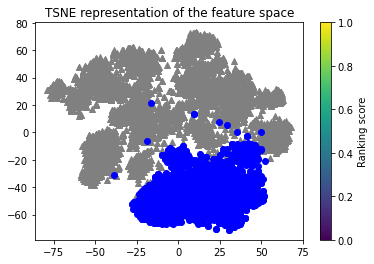

In [28]:
plot_tsne("",
          transformed_space[is_cat == 0],
          transformed_space[is_cat == 1])